In [1]:
import sys
sys.path.append('src')
import numpy as np
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


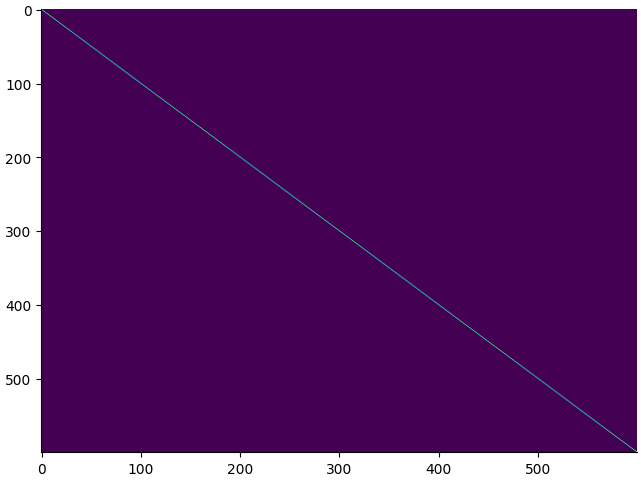

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#
N_shared_channels = 1
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.zeros(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

In [6]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)

In [7]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [8]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 1.7, 1.2, 1.8]) / 4
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)

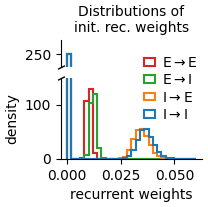

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(2, 2), height_ratios=[1, 3], constrained_layout=False)
fig.subplots_adjust(hspace=0.05)
if issparse(JEE):
    hist = [_.toarray().flatten() for _ in [JII, JEI, JIE, JEE]]
else:
    hist = [_.flatten() for _ in [JII, JEI, JIE, JEE]] 
for i in range(2):
    ax[i].hist(hist, bins=30, density=True, histtype='step', range=(0, 0.06), lw=1.5,
               label=[r'I$\to$I', r'I$\to$E', r'E$\to$I', r'E$\to$E'])
ax[0].set(ylim=[200, 300], yticks=[250], xticks=[])
ax[1].set(ylim=[0, 150], yticks=[0, 100], ylabel='density', xlabel='recurrent weights')
ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=5,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0], [0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0], [1], transform=ax[1].transAxes, **kwargs)
ax[0].set_title('Distributions of\ninit. rec. weights', fontsize=10)
ax[1].legend(bbox_to_anchor=(0.5, 0.3), ncols=1, frameon=False,
             handlelength=0.8, handletextpad=0.5)
fig.tight_layout(pad=0.1)
fig.savefig('svg/J_dist.svg')

In [10]:
rEmax, rImax, thE, thI, sE, sI = 50, 100, -4, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [11]:
w0_mean, w0_std, cW = 1/N_HVC, 1e-2, 1
w_inh = w0_mean*cW
tauE, tauI, dt = 30, 10, 1

net = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
            JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
            w_inh=w_inh, w0_std=w0_std, cW=cW)

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 3981.64it/s]


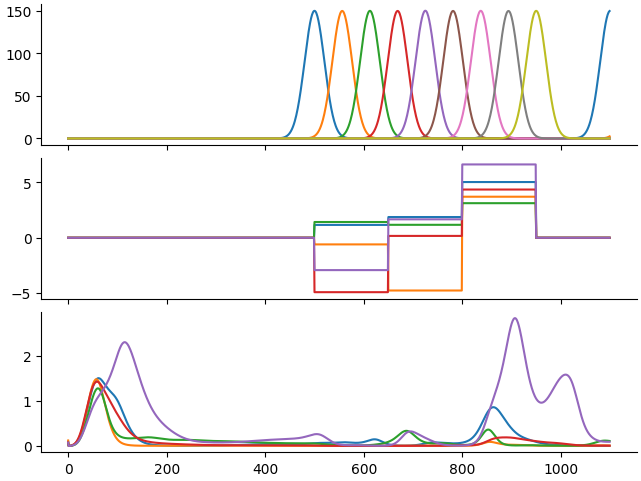

In [12]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
_ = net.sim(hE0, hI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend]*0, [], T_burn+T_rend, dt, 0)
rE = _[0]
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rH[:T_burn+T_rend])
ax[1].plot(aud[:T_burn+T_rend,:5])
ax[2].plot(rE[:T_burn+T_rend,:5]);

100%|███████████████████████████████████████| 999/999 [00:00<00:00, 4076.48it/s]


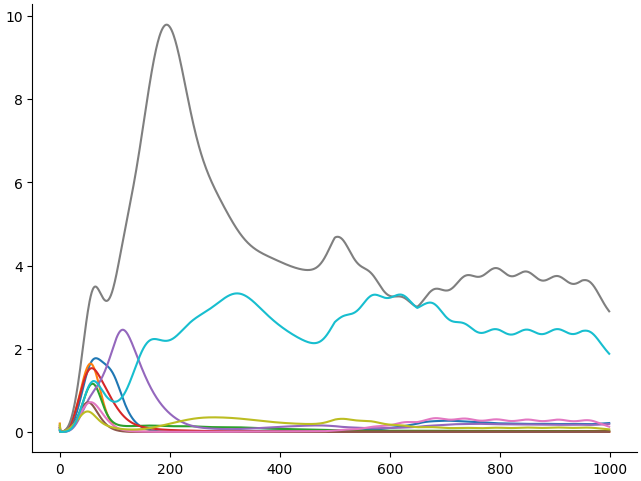

In [13]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
aux = [np.zeros_like(rH[:1000])+rH[:1000].mean(axis=1)[:,None], 
       np.zeros_like(aud[:1000])+aud[:1000].mean(axis=1)[:,None]]
_ = net.sim(hE0, hI0, *aux, [], 1000, dt, 0)
rE, rI, _, _, hE = _
plt.plot(rE[:1000,:10]);

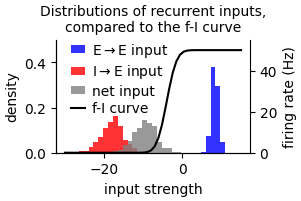

In [14]:
ee_in = (net.JEE @ rE[:500].T).T.mean(axis=0)
ei_in = (net.JEI @ rI[:500].T).T.mean(axis=0)
_ = np.linspace(-30, 15)
fig, ax = plt.subplots(1, figsize=(3, 2))
ax = [ax, ax.twinx()]
ax[1].spines.right.set_visible(True)
ax[0].hist([ee_in-ei_in, -ei_in, ee_in], bins=30, density=True, 
           histtype='stepfilled', alpha=0.8, color=['grey', 'r', 'b'],
           label=[r'net input', r'I$\to$E input', r'E$\to$E input'])
ax[0].plot(0, 0, c='k', label='f-I curve')
ax[0].legend(loc=(0.05, 0.28))
ax[1].plot(_, net.phiE(_), color='k', zorder=10)
ax[0].set(ylabel='density', xlabel='input strength', ylim=[0, 0.5])
ax[0].set_title('Distributions of recurrent inputs,\ncompared to the f-I curve', fontsize=10)
ax[1].set(ylim=[0, 55], ylabel='firing rate (Hz)')
fig.savefig('svg/show_EI_balance.svg', transparent=True)

In [15]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-8e-2), 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = net.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
rE, rI, Ws, mean_HVC_input, hE = _
for k, v in Ws.items():
    if issparse(v[0]):
        Ws[k] = [_.toarray() for _ in v]

100%|███████████████████████████████████| 15499/15499 [00:04<00:00, 3236.14it/s]


(<Figure size 400x600 with 4 Axes>,
 array([<Axes: ylabel='$\\left\\langle \\| W \\|_F \\right\\rangle$'>,
        <Axes: ylabel='mean input\nfrom HVC'>,
        <Axes: ylabel='Mean exc. rate'>,
        <Axes: xlabel='Time (a.u.)', ylabel='Mean inh. rate'>],
       dtype=object))

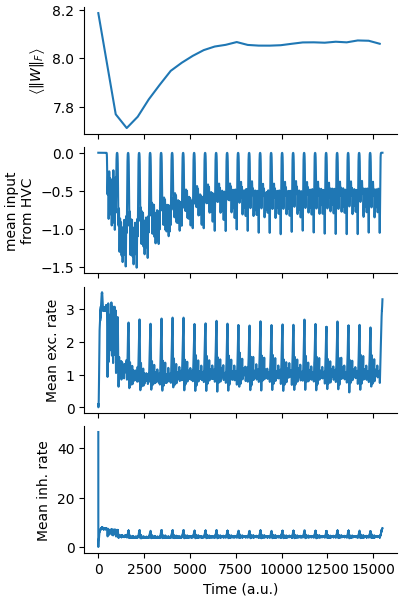

In [16]:
plot_train_stats(Ws['HVC'], rE, mean_HVC_input, save_W_ts, rI)

202


/tmp/ipykernel_4077/2248259974.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout(w_pad=0.2, h_pad=0.5)


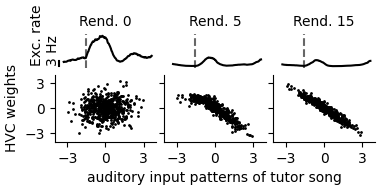

In [22]:
i = 0
rends = (0, 5, 15)
_ = [rE[int(tsyl_start[i,j]):int(tsyl_end[i,j])].mean(axis=0) for j in rends]
k = rng.choice(np.where((_[0]>_[1]+0.5)&(_[1]>_[2]+0.5))[0])
print(k)
fig, ax = plt.subplots(2, 3, figsize=(4, 2), sharey='row', sharex='row', 
                       height_ratios=[1, 2])
for c, j in enumerate(rends):
    ax[0,c].plot(rE[int(tsyl_start[i,j])-50:int(tsyl_end[i,j]),k], color='k')
    ax[0,c].axvline(50, c='k', alpha=0.6, ls='--')
    ax[0,c].set_title('Rend. %d' % j, fontsize=10)
    ax[1,c].plot(normalize(syl[i], 0), normalize(Ws['HVC'][j][:,i*3+1], 0), '.', 
                 ms=2, color='k')
    ax[1,c].set(xlim=[-4, 4], ylim=[-4, 4], xticks=[-3, 0, 3])
    ax[0,c].set_axis_off()
ax[0,0].plot([-10, -10], [0, 3], c='k')
ax[0,0].text(-25, 0, '3 Hz', va='bottom', ha='center', rotation=90)
ax[0,0].text(-60, 0, 'Exc. rate', va='bottom', ha='center', rotation=90)
# ax[0,0].legend(loc=(0, 1), title='Rendition #', ncols=3, frameon=False, 
#            handlelength=1, columnspacing=1)
ax[1,0].set(yticks=[-3, 0, 3], ylabel='HVC weights')
ax[1,1].set_xlabel('auditory input patterns of tutor song')
# 2x3; label HVC inputs vs auditory inputs

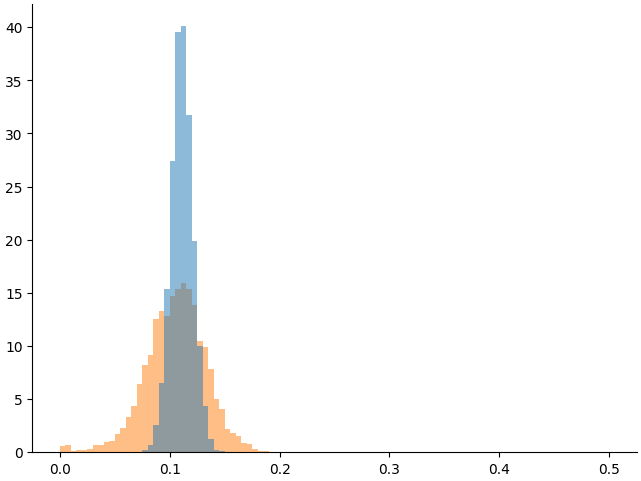

In [18]:
plt.hist([Ws['HVC'][0].flatten(), Ws['HVC'][-1].flatten()], density=True, bins=100, 
           range=(0, 0.5), histtype='stepfilled', alpha=0.5);

## Test Model with Different Scenarios

In [19]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [67]:
exp = Experiment(net, rH, syl, noise=1, T_test=T_burn+T_rend, 
                 t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert = rng.multivariate_normal(pert_mean, pert_cov, size=N_syl)
pert_args = [(pert * 0.5, 1), (pert, 1)]
test_codes = ('correct', 'perturb', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nweak pert.', 'Singing\nstrong pert.',
              'Singing\ndeafen', 'Playback\n')
tests_all = exp.sim_multi(test_codes, if_sing, [None]+pert_args+[None]*2)

100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.20it/s]


In [68]:
rE_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['rE']]
syl_block_avgs = block_apply(syl, K=N_shared_channels, func=np.mean)
bos_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['bos']]

/home/zg93/Projects/Aiv-Network/src/visualization.py:148: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


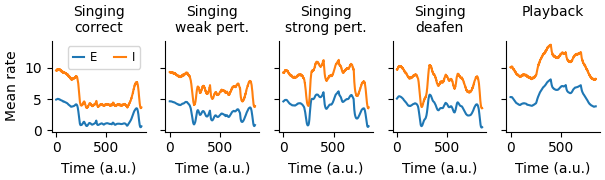

In [69]:
ti, tj = T_burn//2, T_burn+T_rend
fig, ax = plot_tests_mean(tests_all['rE'], tests_all['rI'], test_names, ti, tj)

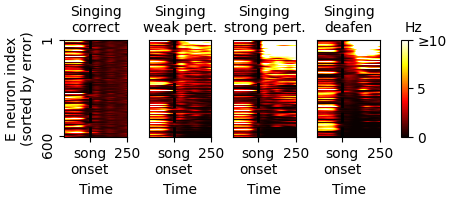

In [71]:
fig, ax = plot_raster_cmp_syl_dsyl(tests_all['rE'][:-1], test_names[:-1], syl[0], 
                                   [_[0]-syl[0] for _ in tests_all['bos']][:-1], 
                                   tsyl_start[0,0], tsyl_end[0,0], 
                                   figsize=(4.5, 2), plot_z=False, sort_by='e', th=10)

/home/zg93/Projects/Aiv-Network/src/visualization.py:286: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


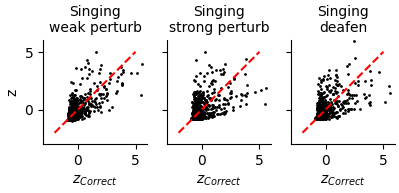

In [57]:
ti, tj = T_burn-100, int(tsyl_end[2,0]) + 100
fig, ax = plot_ctrl_vs_nonctrl(tests_all['rE'][:-1], test_names[:-1], ti, tj)

/home/zg93/Projects/Aiv-Network/src/visualization.py:186: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


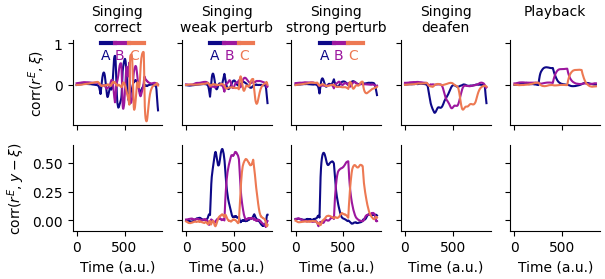

In [58]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs(rE_block_avgs, bos_block_avgs, syl_block_avgs, test_names,
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1)

/home/zg93/Projects/Aiv-Network/src/visualization.py:220: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


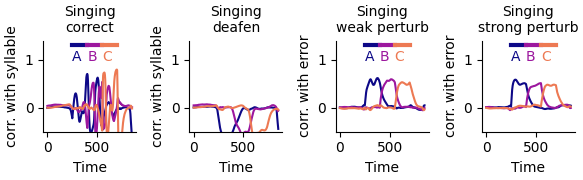

In [59]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
# Do not need to show playback
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs_simple(rE_block_avgs[:-1], bos_block_avgs[:-1], 
                                  syl_block_avgs, test_names[:-1],
                                  ti, tj, tid_perturb_input=(1, 2), 
                                  syl_order=so, y=1.3)

412 188
90 60


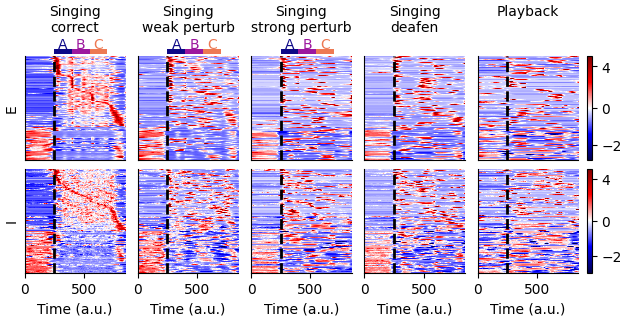

In [60]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_heatmap(tests_all, test_names, 
                             ti, tj, T_burn, plot_inh=True, syl_order=so)

/home/zg93/Projects/Aiv-Network/src/visualization.py:305: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


[(-1.0, 1.0)]

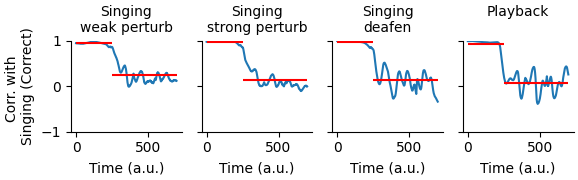

In [61]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all['rE'], test_names, ti, tj, T_burn)
# fig, ax = plot_corr_ctrl_nonctrl(rE_block_avgs, test_names, ti, tj, T_burn)
ax[0].set(ylim=[-1, 1])

/home/zg93/Projects/Aiv-Network/src/visualization.py:329: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


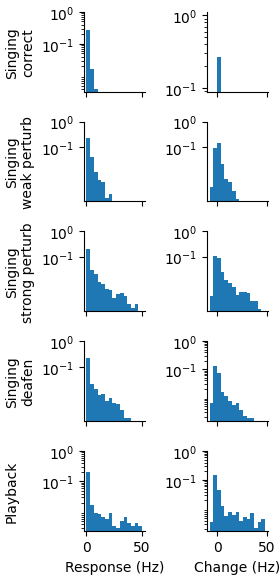

In [62]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all['rE'], test_names, tests_all['rE'][0], ti, tj)
# fig, ax = plot_rate_and_change_dists(rE_block_avgs, test_names, rE_block_avgs[0], ti, tj)